# **DESAFIO 3 G2** 
# **Dataset Imagenes Covid-19 - Modelo de clasificacion supervisado.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#section_toc)

Armado y presentacion de dataset

$\hspace{.5cm}$[Importaciones y carga de bibliotecas](#sec_imp)

$\hspace{.5cm}$[Alcance del trabajo y caracteristicas generales](#sec_alcance)

$\hspace{.5cm}$[Analisis previos y observacion de variables](#sec_apo)

$\hspace{.9cm}$[Inspeccion de variables](#sec_apo_ds)

$\hspace{.9cm}$[Caracteristicas generales del dataset](#sec_apo_nc)

Implementacion de modelos de clasificacion supervisados

$\hspace{.5cm}$[Armado de set de entrenamiento y testing](#sec_set)
  
$\hspace{.5cm}$[KNeighborsClassifier](#sec_knn)

$\hspace{.9cm}$[Analisis](#sec_knn_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_knn_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_knn_eval)

$\hspace{.5cm}$[Gaussian Naive Bayes](#sec_gnb)

$\hspace{.9cm}$[Analisis](#sec_gnb_a)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_gnb_eval)

$\hspace{.5cm}$[Logistic Regression](#sec_lr)

$\hspace{.9cm}$[Analisis](#sec_lr_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_lr_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_lr_eval)

Conclusiones

$\hspace{.5cm}$[Conclusiones](#sec_conclusiones)

---

## Armado y presentacion de dataset

<a id="sec_imp"></a> 
### Importaciones y carga de bibliotecas

[volver a TOC](#section_toc)

In [1]:
!pip install opencv-python

#### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

#### Importacion de librerias para armado y testeo de modelos

In [5]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline, make_union

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

# normalizacion de variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

#### Variables globales

In [6]:
# path relativo al repositorio de imagenes
this_path = os.path.dirname('.')
rel_dataset_path = '../../data/xrays_dataset_completo/'

# path absoluto al repositorio de imagenes
abs_dataset_path = os.path.abspath(os.path.join(this_path, rel_dataset_path))

# path absoluto a dataset de training y a dataset testing
# photos1
photos1_dataset_path = os.path.join(abs_dataset_path, "photos1")
# photos2
photos2_dataset_path = os.path.join(abs_dataset_path, "photos2")
# photos3
photos3_dataset_path = os.path.join(abs_dataset_path, "photos3")

# expresion regular para buscar solamente imagenes
pat = '(jpeg|jpg|png)$'
reg = re.compile(pat, flags = re.IGNORECASE)

<a id="sec_alcance"></a> 
### Alcance de trabajo y caracteristicas generales

[volver a TOC](#section_toc)

#### **Rx de tórax en pacientes COVID-19**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7269964/

Las radiografías de tórax son la modalidad de imagen más utilizada para casos de Covid-19 sospechosos y confirmados.
Los hallazgos en las imágenes pueden variar según la etapa de la enfermedad (días desde los primeros síntomas) y según la gravedad de la misma. Ejemplo:

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/severidad_covid19.jpg" alt="Drawing" style="width: 600px;"/>

La sensibilidad del método varía según los hallazgos y según la técnica: en promedio 69%, y la especificidad es baja, promedio 40%.

TÉCNICA:
 * paciente en bipedestación 
 * apoya el pecho al centro de chasis con las muñecas colocadas en las caderas y los hombros hacia delante.
 *  El rayo debe dirigirse horizontalmente al centro del chasis o hacia la altura de la sexta vértebra dorsal con distancia tubo-película de 1,80 y no debe ser menor a 1,5 m.
 *  en inspiración completa.

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/radiografia_tecnica.png" alt="Drawing" style="width: 400px;"/>


##### **Hallazgos de RX de tórax en pacientes con COVID-19**
 https://pubs.rsna.org/doi/10.1148/radiol.2020201160

Lo más frecuente que podemos encontrar son infiltrados en los campos pulmonares con distintos grados (desde vidrio esmerilado hasta consolidación del parénquima pulmonar),que suelen estar en zonas periféricas del pulmón.

Ejemplo de grados:

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/foto_grados_covid19.jpg" alt="Drawing" style="width: 600px;"/>


##### **Hallazgos de RX de tórax en pacientes con COVID-19** 
 https://pubs.rsna.org/doi/10.1148/ryct.2020200280

En este último cuadro podemos ver que pacientes con COVID + pueden tener RX normales.

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/table2.jpg" alt="Drawing" style="width: 600px;"/>
<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/table3.png" alt="Drawing" style="width: 600px;"/>


La tomografía de tórax tiene mayor sensibilidad y especificidad, de cualquier modo es difícil poder diferenciar. 
Excepto por una mayor prevalencia de distribución periférica, la afectación de los lóbulos superior y medio, la neumonía viral COVID-19 y no COVID presentaron hallazgos de TC de tórax superpuestos.

 * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7233414/
 * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7320914/

**COMPARACIÓN CON OTRAS NEUMONÍAS VÍRICAS**

Recientemente se ha publicado un estudio comparativo entre la neumonía por COVID y otras neumonías víricas. Las características más discriminatorias para la neumonía por COVID-19 incluyeron:
 * Distribución periférica (80% vs. 57%, p <0.001)
 * Opacidad de vidrio deslustrado (91% vs. 68%, p <0.001)
 * Engrosamiento vascular (58% frente a 22%, p <0,001).
Pese a este estudio la opinión más extendida es que la neumonía por COVID-19 y otras neumonías víricas pueden ser indistinguibles, de aquí nace la dificultad diagnóstica.



<a id="sec_apo"></a> 
### Analisis previos y observacion de variables

[volver a TOC](#section_toc)

Fuente de repositorio de imagenes:

* [Covid-19 Image Dataset](https://www.kaggle.com/pranavraikokte/covid19-image-dataset). Usability: 8.8
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Las imagenes fueron liberadas por la Universidad de Montreal.


* [COVID19 High quality images](https://www.kaggle.com/theroyakash/covid19). Usability: 5.0
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Fuente no oficial. Imagenes extraidas desde sitios publicos mediante Web Scrapping.

Ambos datasets se encuentran dispuestos en una estructura de directorios que comienza con la separacion de carpetas de training y testing. Luego a partir de estas carpetas se crean nuevas carpetas que identifican los casos de Covid, Neumonia y casos sin afecciones.

Para poder distribuir de forma uniforme el set de datos utilizados para testing y training, unificamos ambos repositorios en la siguiente estructura de directorios:

<code>
$ tree -d .

.
├── photos1
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
├── photos2
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
└── photos3
    ├── Covid
    ├── Normal
    └── Viral Pneumonia
</code>

Con el armado del dataset delegaremos luego en los metodos `train_test_split()` y `StratifiedKFold()` de la bilbioteca scikit-learn la distribucion del set de datos para training y testing.

<a id="sec_apo_ds"></a> 
#### Inspeccion de variables

[volver a TOC](#section_toc)

**Comprobacion de carga de ruta de imagenes desde el sistema operativo**

In [7]:
path_label = [path for path in os.listdir(photos1_dataset_path)]

In [8]:
print(path_label)

['Covid', 'Normal', 'Viral Pneumonia']


#### Inspeccion de imagenes

**Coronavirus**

A continuacion se presentan imagenes de ejemplo de pacientes con Covid-19. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [9]:
imcor1 = cv2.imread(rel_dataset_path + '/photos1/Covid/0100.jpeg', cv2.COLOR_BGR2GRAY)
imcor2 = cv2.imread(rel_dataset_path + '/photos1/Covid/0102.jpeg', cv2.COLOR_BGR2GRAY)
imcor3 = cv2.imread(rel_dataset_path + '/photos1/Covid/0105.png', cv2.COLOR_BGR2GRAY)
imcor4 = cv2.imread(rel_dataset_path + '/photos1/Covid/0106.jpeg', cv2.COLOR_BGR2GRAY)

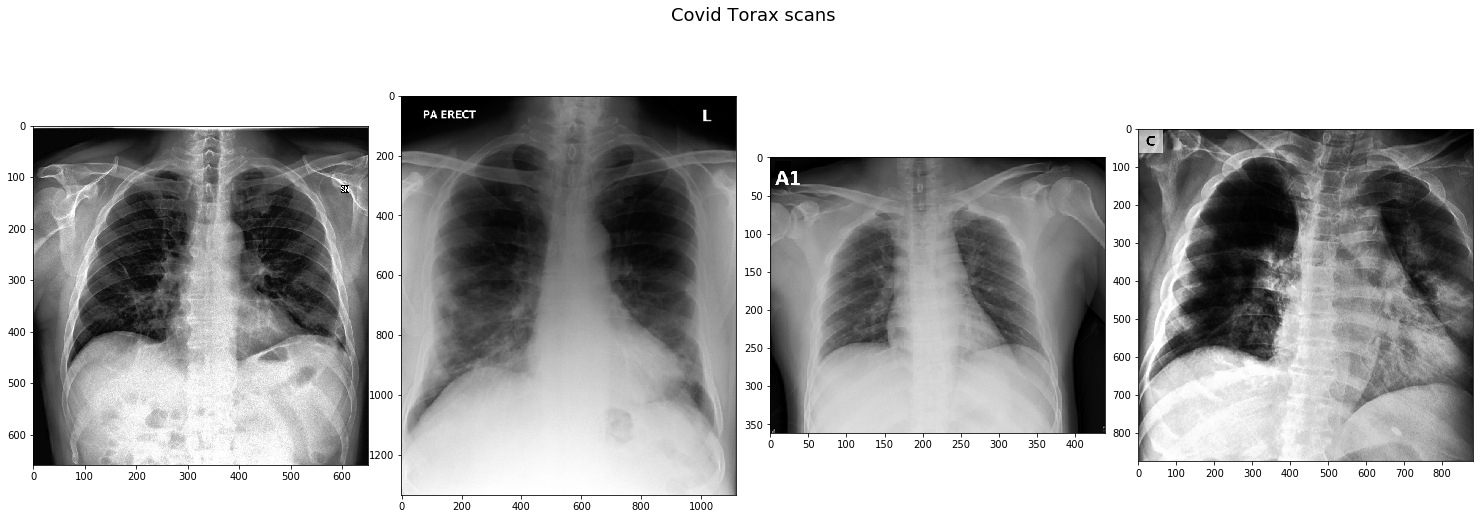

In [10]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Covid Torax scans', y=0.70, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imcor1)
axs[1].imshow(imcor2)
axs[2].imshow(imcor3)
axs[3].imshow(imcor4)
plt.show()

**Neumonia**

A continuacion se presentan imagenes de ejemplo de pacientes con Neumonia. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [11]:
imneu1 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0101.jpeg', cv2.COLOR_BGR2GRAY)
imneu2 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0102.jpeg', cv2.COLOR_BGR2GRAY)
imneu3 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0103.jpeg', cv2.COLOR_BGR2GRAY)
imneu4 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0104.jpeg', cv2.COLOR_BGR2GRAY)

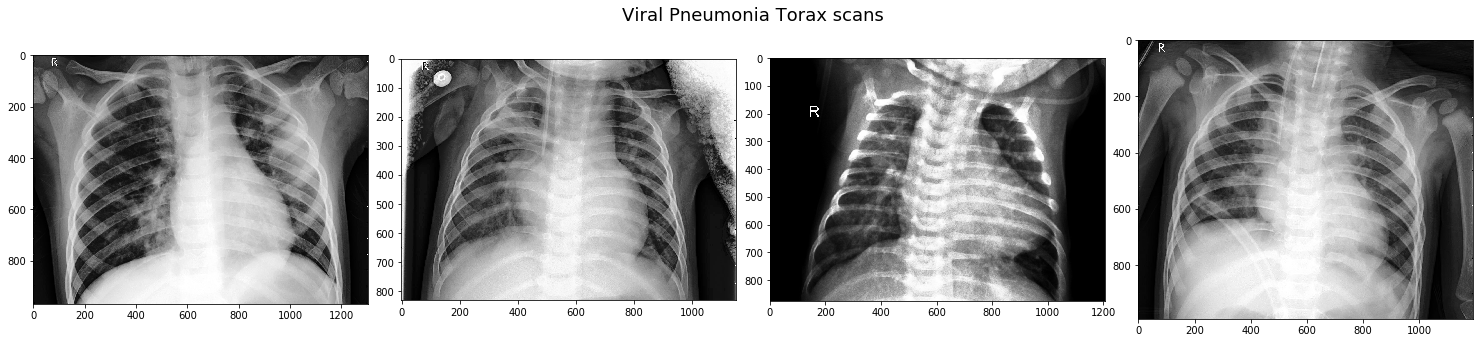

In [12]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Viral Pneumonia Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imneu1)
axs[1].imshow(imneu2)
axs[2].imshow(imneu3)
axs[3].imshow(imneu4)
plt.show()

**Normal**

A continuacion se presentan imagenes sin ninguna afeccion pulmonar. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [13]:
imnor1 = cv2.imread(rel_dataset_path + '/photos1/Normal/0101.jpeg', cv2.COLOR_BGR2GRAY)
imnor2 = cv2.imread(rel_dataset_path + '/photos1/Normal/0102.jpeg', cv2.COLOR_BGR2GRAY)
imnor3 = cv2.imread(rel_dataset_path + '/photos1/Normal/0103.jpeg', cv2.COLOR_BGR2GRAY)
imnor4 = cv2.imread(rel_dataset_path + '/photos1/Normal/0105.jpeg', cv2.COLOR_BGR2GRAY)

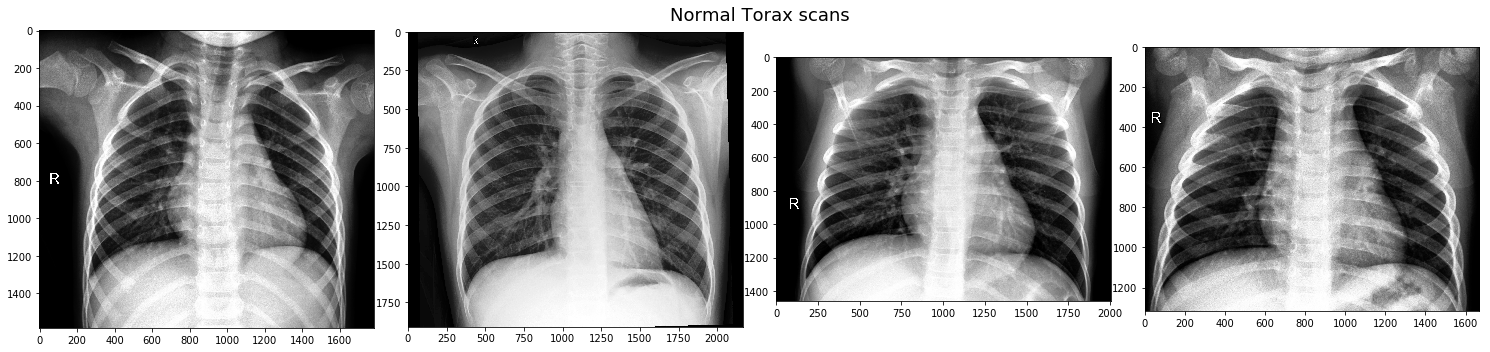

In [14]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Normal Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imnor1)
axs[1].imshow(imnor2)
axs[2].imshow(imnor3)
axs[3].imshow(imnor4)
plt.show()

<a id="sec_apo_ds"></a> 
### Caracteristicas generales del dataset.

[volver a TOC](#section_toc)

**Parametros de tratamiento general sobre las imagenes**

Analisis segun las siguientes condiciones:
   
 * Tamaño de imagenes ajustados a 100 pixeles x 100 pixeles.
 * Uso de escala de grises.
 * Uso de [**Biblioteca OpenCV**](https://opencv.org/)
 
La biblioteca OpenCV permitio facilmente trabajar con el mapa de bits de cada pixel gracias a su integracion con Numpy. A traves de la utilizacion de metodos de OpenCV podemos generar una matriz de np.array con la distribucion de colores de cada pixel.
A traves del metodo `flatten()` de OpenCV es posible transformar la matriz np.array en un vector. 

Entonces cada vector constituira una imangen de 100 x 100 pixeles distribuida en una sola dimension.

**Imagen ejemplo**

In [15]:
imgtest = cv2.imread(rel_dataset_path + '/photos1/Covid/0100.jpeg', cv2.IMREAD_COLOR)

In [16]:
imgtest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY)

In [17]:
imgtest = cv2.resize(imgtest, (100,100))

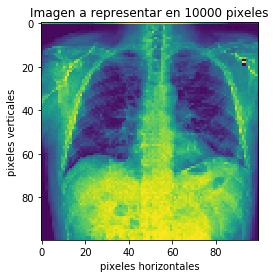

In [18]:
plt.imshow(imgtest)
plt.xlabel('pixeles horizontales')
plt.ylabel('pixeles verticales')
plt.title('Imagen a representar en 10000 pixeles')
plt.show()

In [19]:
imgtest.shape

(100, 100)

In [20]:
imgtest.flatten().shape

(10000,)

**Armado de dataset**

La funcion `new_dataset()` se desarrollo para poder transformar los distintos repositorios de imagenes en una matriz que contenga una lista de vectores correspondiente a cada imagen a analizar.

In [21]:
def new_dataset(dataset_path):
    '''
    creacion de nuevo dataset a partir de repositorio de imagenes
    dataset_path: ruta absoluta donde se encuentran las imagenes, test o train
    salida: tupla con:
        * matriz de dos dimensiones con mapa de bits de cada imagen (cada registro o lista de una dimension es una imagen) - Feature
        * lista de una dimension con valores numericos que representan la clase a la que pertenece la imagen - Target
        * lista de una dimension con las etiquetas de clase a la que pertenece cada imagen
    '''
    imgs_label = []
    imgs = []
    for pathlabel in os.listdir(dataset_path):
        label = os.path.join(dataset_path, pathlabel)
        for file in os.listdir(label):
            if re.search(pat, file) is not None:
                img = cv2.imread(os.path.join(label, file), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100,100))
                img = img.flatten()
                imgs.append(img)
                imgs_label.append(pathlabel)
                
    label_to_id_dict = {v:i for i,v in enumerate(np.unique(imgs_label))}
    label_ids = np.array([label_to_id_dict[x] for x in imgs_label])
    
    return np.array(imgs), label_ids, np.array(imgs_label)

### Preparacion del dataset

Unificacion de set de train y testing para aplicar una estrategia de separacion a traves de los metodos de scikit learn. Se busca mantener la proporcionalidad de la clases de la variable target.

In [22]:
photos1_X, photos1_y, photos1_labels = new_dataset(photos1_dataset_path)
photos2_X, photos2_y, photos2_labels = new_dataset(photos2_dataset_path)
photos3_X, photos3_y, photos3_labels = new_dataset(photos3_dataset_path)

**Features**

Matriz que contiene en cada vector la distribucion de colores por pixel de cada imagen.

In [23]:
photos1_X

array([[203, 187, 180, ...,  13,   9,   7],
       [  0,   0,   0, ..., 192, 168, 125],
       [  7,   8,   8, ...,  11,  12,  30],
       ...,
       [ 30,  31,  32, ...,  10,  12,  14],
       [ 47,  45,  44, ...,  15,  15,  15],
       [ 93, 102, 114, ...,  15,  17,  17]], dtype=uint8)

**Target**

Labels que hacen referencia a que clase pertenece cada vector.

Entonces:
 * 0 - Corresponde a los enfermos con COVID: **_Covid_**.
 * 1 - Corresponde a los pacientes saludables: **_Normal_**.
 * 2 - Corresponde a los enfermos con Neumonía: **_Viral Pneumonia_**.

In [24]:
photos1_labels

array(['Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

In [25]:
photos1_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Estructura de cada set de imagenes cargado.

In [26]:
display(photos1_X.shape, photos1_y.shape, photos1_labels.shape)
display(photos2_X.shape, photos2_y.shape, photos2_labels.shape)
display(photos3_X.shape, photos3_y.shape, photos3_labels.shape)

(66, 10000)

(66,)

(66,)

(251, 10000)

(251,)

(251,)

(353, 10000)

(353,)

(353,)

**Features y target como objetos de pandas**

La estructura final del dataset de features esta conformado por:

* 670 imagenes estructuradas en vectores.
* 10000 features correspondientes a la escala de colores de cada pixel representado entre 0 a 255.

In [27]:
numpy_append = np.append(photos1_X, photos2_X, axis=0)
data_features = pd.DataFrame(np.append(numpy_append, photos3_X, axis=0))

In [28]:
data_features

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,203,187,180,169,171,167,161,163,159,154,...,97,101,119,86,79,63,31,13,9,7
1,0,0,0,0,0,0,0,0,0,0,...,231,228,228,216,210,212,202,192,168,125
2,7,8,8,8,7,7,7,6,6,5,...,36,28,2,2,5,8,10,11,12,30
3,169,169,167,171,173,169,154,56,18,68,...,140,132,128,120,102,95,92,81,78,70
4,143,144,144,144,144,148,10,3,3,4,...,29,28,24,21,18,18,14,14,14,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,5,5,4,5,4,4,2,0,0,0,...,14,0,0,0,0,0,0,0,0,0
666,45,42,39,36,32,24,18,19,27,43,...,18,14,42,44,46,22,20,20,21,21
667,0,0,0,0,0,0,7,17,32,51,...,121,94,32,9,0,0,0,0,0,0
668,0,0,0,6,13,50,68,81,92,94,...,185,181,134,105,51,0,0,0,0,0


**Target**

In [29]:
numpy_append = np.append(photos1_y, photos2_y, axis=0)
data_target = pd.Series(np.append(numpy_append, photos3_y, axis=0))

**Dataset final**

In [30]:
data_features.shape, data_target.shape

((670, 10000), (670,))

---

## Implementacion de modelos de clasificacion supervisados

<a id="sec_set"></a> 
### Armado de set de entrenamiento y testing

[volver a TOC](#section_toc)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, stratify=data_target, random_state=0)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((502, 10000), (168, 10000), (502,), (168,))

In [33]:
y_train.value_counts(normalize=True)

1    0.344622
0    0.342629
2    0.312749
dtype: float64

In [34]:
y_test.value_counts(normalize=True)

1    0.345238
0    0.339286
2    0.315476
dtype: float64

**Escalado de valores**

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
X_train

array([[ 0.41889177,  0.36039372,  0.32501001, ...,  0.3611501 ,
         0.42653605,  0.45400028],
       [-0.43933107, -0.50994844, -0.5613879 , ..., -0.37423204,
        -0.29240302, -0.28789998],
       [ 2.97448868,  2.87681778,  2.86858662, ...,  1.69509909,
         1.72413339,  1.684469  ],
       ...,
       [ 0.81939576,  1.02261058,  1.21140792, ..., -0.51104732,
        -0.57296461, -0.57742203],
       [ 2.05905098,  2.00647562,  2.00145823, ..., -0.35713013,
        -0.32747322, -0.30599511],
       [ 4.19507228,  4.10664909,  4.12110541, ...,  1.09653224,
         0.49667645,  0.23685874]])

In [37]:
# Comprobacion de variables para verificar que la media de cada valor sea cero (0) y el desvio estandar sea uno (1).
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

Medias: [ 0.  0.  0. ...  0. -0.  0.]
Desvio: [1. 1. 1. ... 1. 1. 1.]


---

### KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

<a id="sec_knn_a"></a> 
#### Analisis

[volver a TOC](#section_toc)

**Stratified K-Folds**

Utilizacion de separacion en _folds_ los registros del dataset de training para utilizar en una estrategia de cross validation.
Los _folds_ utilizan features estadarizados previamente y permiten preservar el porcentaje de muestras para cada clase.

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [39]:
scores_para_df_standard = []

for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

Creacion de dataframe a partir de diccionario y creacion de limites sobre score medio.

In [40]:
df_knn_scores_standard = pd.DataFrame(scores_para_df_standard)

In [41]:
df_knn_scores_standard['limite_superior'] = df_knn_scores_standard['score_medio'] + df_knn_scores_standard['score_std']
df_knn_scores_standard['limite_inferior'] = df_knn_scores_standard['score_medio'] - df_knn_scores_standard['score_std']
df_knn_scores_standard.sort_values(by='score_medio', ascending=False).head(5)

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
10,0.878495,0.050174,11,0.928669,0.828321
5,0.874535,0.022204,6,0.896739,0.852330
7,0.870594,0.040199,8,0.910793,0.830395
9,0.870554,0.043552,10,0.914106,0.827003
19,0.870535,0.038922,20,0.909456,0.831613


Graficamos los resultados

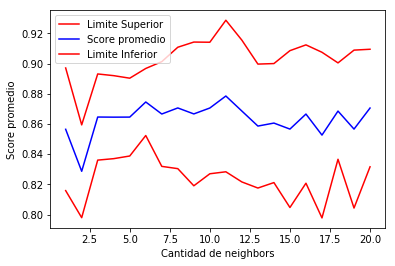

In [42]:
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['limite_inferior'], color='r', label='Line 2')
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['score_medio'], color='b', label='Line 1')
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['limite_superior'], color='r', label='Line 3');
plt.xlabel('Cantidad de neighbors')
plt.ylabel('Score promedio')
plt.legend(['Limite Superior', 'Score promedio', 'Limite Inferior'])

plt.show()

Score máximo

In [43]:
df_knn_scores_standard.loc[df_knn_scores_standard.score_medio == df_knn_scores_standard.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
10,0.878495,0.050174,11,0.928669,0.828321


Segun el mejor valor posible para el hiperparámetro `n_neighbors`, reentrenamos el modelo para evaluar los resultados sobre el set de _test_.

In [44]:
best_k = df_knn_scores_standard.loc[df_knn_scores_standard.score_medio == df_knn_scores_standard.score_medio.max(), 'n_neighbors'].values[0:2]
best_k

array([11], dtype=int64)

In [45]:
model = KNeighborsClassifier(n_neighbors=best_k[0])
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

Determinamos el accuracy score para los datos de training

In [46]:
accuracy_score(y_train, model.predict(X_train))

0.9063745019920318

El modelo de KNN con el mejor valor de k alcanzo un _accuracy score_ del orden del 89% sobre los datos de entrenamiento. Veamos si es capaz de generalizar sobre el set de datos de testing y mantener un nivel de _performance_ similar.

In [47]:
y_pred = model.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.8452380952380952

<a id="sec_knn_gs"></a> 
#### Optimizacion de hiperparametros mediante GridSearchCV

[volver a TOC](#section_toc)

**Seleccion de parametros del modelo**

Como metrica de evaluacion utilizamos accuracy y precision

In [49]:
# Hiperparametros del modelo.
k_range = list(range(1, 16))
weight_opt = ['uniform', 'distance']
metric_opt = ['manhattan', 'minkowski']

# Metricas de evaluacion
#scoring = 'accuracy'

scoring = ['accuracy', 'precision_macro', 'recall_macro']

Creacion de la grilla de hiperparametros del modelo

In [50]:
knn = KNeighborsClassifier()

In [51]:
param_grid = dict(n_neighbors=k_range, weights=weight_opt, metric=metric_opt)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'minkowski']}


In [52]:
#grid = GridSearchCV(knn, param_grid, cv=skf, return_train_score=True, scoring=scoring)
grid = GridSearchCV(knn, param_grid, n_jobs = -1, cv=skf, refit='accuracy', return_train_score=True, scoring=scoring)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro', 'recall_macro'],
             verbose=0)

In [53]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_accuracy', 'split4_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy', 'split0_test_precision_macro', 'split1_test_precision_macro', 'split2_test_precision_macro', 'split3_test_precision_macro', 'split4_test_precision_macro', 'mean_test_precision_macro', 'std_test_precision_macro', 'rank_test_precision_macro', 'split0_train_precision_macro', 'split1_train_precision_macro', 'split2_train_precision_macro', 'split3_train_precision_macro', 'split4_train_precision_macro', 'mean_train_precision_macro', 'std_train_precision_macro', 'split0_test_recall_macro', 'split1_test

In [54]:
grid_results = pd.DataFrame(grid.cv_results_)
pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_accuracy,split1_test_accuracy,...,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_train_recall_macro,split1_train_recall_macro,split2_train_recall_macro,split3_train_recall_macro,split4_train_recall_macro,mean_train_recall_macro,std_train_recall_macro
7,0.975790,0.051091,1.091083,0.094379,manhattan,4,distance,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.920792,0.881188,...,0.901007,0.038512,1,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
11,1.071534,0.066613,1.165284,0.088302,manhattan,6,distance,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.930693,0.841584,...,0.889354,0.038570,2,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
15,1.060962,0.114899,1.198595,0.069079,manhattan,8,distance,"{'metric': 'manhattan', 'n_neighbors': 8, 'wei...",0.910891,0.861386,...,0.887573,0.031627,3,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
10,0.964021,0.063678,1.091282,0.076136,manhattan,6,uniform,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.900990,0.831683,...,0.884942,0.039898,7,0.92536,0.927093,0.938463,0.927421,0.928111,0.92929,0.004676
23,1.071135,0.051804,1.138955,0.078528,manhattan,12,distance,"{'metric': 'manhattan', 'n_neighbors': 12, 'we...",0.891089,0.851485,...,0.885746,0.037410,4,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000


In [55]:
grid_results.shape

(60, 53)

In [56]:
grid_results.loc[:,['mean_test_recall_macro','mean_test_precision_macro','mean_test_accuracy','rank_test_precision_macro','rank_test_recall_macro', 'rank_test_accuracy', 'param_n_neighbors']] \
.sort_values(by='rank_test_precision_macro', ascending=True) \
.head(3)

,mean_test_recall_macro,mean_test_precision_macro,mean_test_accuracy,rank_test_precision_macro,rank_test_recall_macro,rank_test_accuracy,param_n_neighbors
7,0.901007,0.903781,0.900396,1,1,1,4
11,0.889354,0.892994,0.888455,2,2,2,6
15,0.887573,0.892041,0.886455,3,3,3,8


In [57]:
grid_results.loc[:,['mean_test_recall_macro','mean_test_precision_macro','mean_test_accuracy','rank_test_precision_macro','rank_test_recall_macro', 'rank_test_accuracy', 'param_n_neighbors']] \
.sort_values(by='rank_test_recall_macro', ascending=True) \
.head(3)

,mean_test_recall_macro,mean_test_precision_macro,mean_test_accuracy,rank_test_precision_macro,rank_test_recall_macro,rank_test_accuracy,param_n_neighbors
7,0.901007,0.903781,0.900396,1,1,1,4
11,0.889354,0.892994,0.888455,2,2,2,6
15,0.887573,0.892041,0.886455,3,3,3,8


In [58]:
grid_results.loc[:,['mean_test_recall_macro','mean_test_precision_macro','mean_test_accuracy','rank_test_precision_macro','rank_test_recall_macro', 'rank_test_accuracy', 'param_n_neighbors']] \
.sort_values(by='rank_test_accuracy', ascending=True) \
.head(3)

,mean_test_recall_macro,mean_test_precision_macro,mean_test_accuracy,rank_test_precision_macro,rank_test_recall_macro,rank_test_accuracy,param_n_neighbors
7,0.901007,0.903781,0.900396,1,1,1,4
11,0.889354,0.892994,0.888455,2,2,2,6
15,0.887573,0.892041,0.886455,3,3,3,8


In [59]:
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')
0.9003960396039604
{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


<a id="sec_knn_eval"></a> 
#### Metricas y evaluacion del modelo

[volver a TOC](#section_toc)

In [60]:
y_pred_grid = grid.predict(X_test)

**Matriz de confusion**

In [61]:
cm = confusion_matrix(y_test, y_pred_grid)
cm

array([[53,  3,  1],
       [ 2, 47,  9],
       [ 3,  7, 43]], dtype=int64)

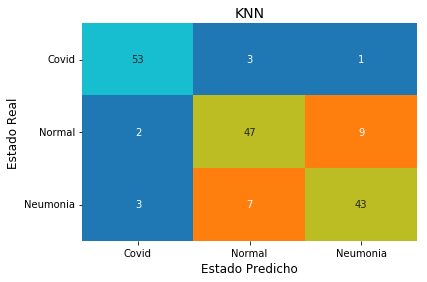

In [62]:
xticks=['Covid','Normal', 'Neumonia']
yticks=['Covid','Normal', 'Neumonia']

sns.heatmap(cm, annot=True, xticklabels=xticks, yticklabels=yticks, cbar=False, fmt='.0f', cmap="tab10")

plt.yticks(rotation=0, fontsize="10", va="center")
plt.title('KNN', fontsize = 14)
plt.ylabel('Estado Real', fontsize = 12)
plt.xlabel('Estado Predicho', fontsize = 12)

plt.show()

**Classification Report**

In [63]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        57
           1       0.82      0.81      0.82        58
           2       0.81      0.81      0.81        53

    accuracy                           0.85       168
   macro avg       0.85      0.85      0.85       168
weighted avg       0.85      0.85      0.85       168



**Interpretacion de la matriz de confusión:**

Recordemos:
* 0 - Corresponde a los enfermos con COVID
* 1 - Corresponde a los pacientes saludables
* 2 - Corresponde a los enfermos con Neumonía

Siendo los casos positivos los que 'pacientes sanos'.  El mayor riesgo corresponde al falso positivo donde se predijo que estaba sano mientras estaba enfermo.

**Metricas**

Asigamos variable a la matriz de confusión

In [64]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [65]:
accuracy_knn = accuracy_score(y_test, y_pred_grid).round(2)
print('Accuracy=', accuracy_score(y_test, y_pred_grid).round(2)*100,'%')

Accuracy= 85.0 %


**Sensitivity (o recall)**

TP / TP + FN

In [66]:
recall_knn = (TP / (TP + FN)).round(2)
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

recall= 75.0 %


**Specificity**

TN / (TN + FP)

In [67]:
specificity_knn = (TN / (TN + FP)).round(2)
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

Specificity= 90.0 %


**Precision**

TP / (TP + FP)

In [68]:
precision_knn = (TP / (TP + FP)).round(2)
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')

Precision= 80.0 %


**False positive rate (FPR)**

(1 - Specificity)

In [69]:
fpr_knn = (1 - (TN / (TN + FP))).round(2)
print('FPR=', 100-((TN / (TN + FP))).round(2)*100,'%')

FPR= 10.0 %


**F1-Score**

2*(Precision * Recall) / precision + Recall

In [70]:
f1s_knn = 2*((precision_knn * recall_knn) / (precision_knn + recall_knn)).round(2)
print ('F1-Score=', 2*((precision_knn * recall_knn) / (precision_knn + recall_knn)).round(2)*100,'%')

F1-Score= 78.0 %


*Conclusión:*  Analizando los resultados sobre las métricas del modelo KNN se distingue un razonable Accuracy; pero por el caso de negocio sobre el que estamos trabajando, parece poco razonable el nivel existente de FPR:  es demasiado alto, y corremos el riesgo de no poder identificar casos en pacientes enfermos y confundirlos con personas sanas.

In [71]:
results=grid.cv_results_
#results.keys()
X_axis = np.linspace(0, len(results['mean_test_accuracy']),60)

In [72]:
len(results['mean_test_accuracy'])

60

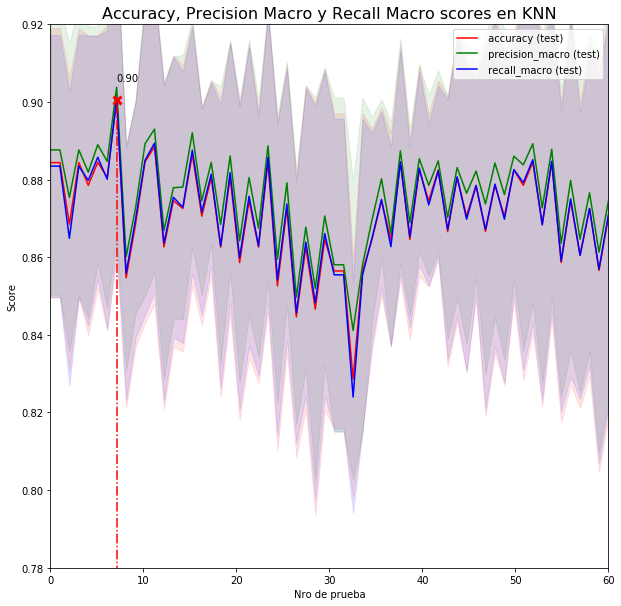

In [73]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy, Precision Macro y Recall Macro scores en KNN",fontsize=16)

plt.xlabel("Nro de prueba")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 60)
ax.set_ylim(0.78, 0.92)

for scorer, color in zip(sorted(scoring), ['r', 'g', 'b']):

    sample, style = ('test', '-')
    sample_score_mean = results[f'mean_{sample}_{scorer}']
    sample_score_std = results[f'std_{sample}_{scorer}']

    ax.fill_between(X_axis, sample_score_mean - sample_score_std, sample_score_mean + sample_score_std, alpha=0.1 if sample == 'test' else 0, color=color)
    ax.plot(X_axis, sample_score_mean, style, color=color, alpha=1 if sample == 'test' else 0.7, label=f' {scorer} ({sample})')

best_index = np.nonzero(results['rank_test_accuracy'] == 1)[0][0]
best_score = results['mean_test_accuracy'][best_index]

ax.plot([X_axis[best_index], ] * 2, [0, best_score], linestyle='-.', color='r', marker='x', markeredgewidth=3, ms=8)

ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

---

### Gaussian Naive Bayes

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

<a id="sec_gnb"></a> 
#### Analisis

[volver a TOC](#section_toc)

Instanciamos el modelo y lo entrenamos con el set de datos de training

In [74]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

**Predict**

Usemos el modelo entrenado en el paso anterior para predecir la etiqueta de los datos de test

In [75]:
y_pred = gnb.predict(X_test)

y_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 1,
       1, 0, 0, 2, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1,
       1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2,
       1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1,
       2, 0, 0, 1, 2, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0,
       0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 1])

<a id="sec_gnb_eval"></a> 
#### Metricas y evaluacion del modelo

[volver a TOC](#section_toc)

Calculemos la matriz de confusión sobre los datos de test y grafiquemos el heatmap de esta matriz.

In [76]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[51,  5,  1],
       [ 1, 46, 11],
       [ 2,  5, 46]], dtype=int64)

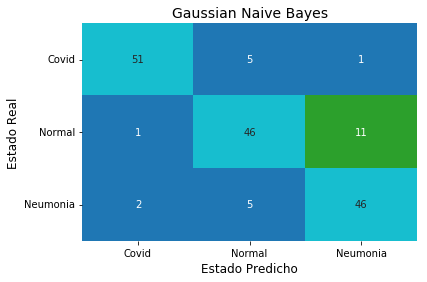

In [77]:
sns.heatmap(cm, annot=True, xticklabels=xticks, yticklabels=yticks, cbar=False, fmt='.0f', cmap="tab10")

plt.yticks(rotation=0, fontsize="10", va="center")
plt.title('Gaussian Naive Bayes', fontsize = 14)
plt.ylabel('Estado Real', fontsize = 12)
plt.xlabel('Estado Predicho', fontsize = 12)

plt.show()

**Classification Report**

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92        57
           1       0.82      0.79      0.81        58
           2       0.79      0.87      0.83        53

    accuracy                           0.85       168
   macro avg       0.85      0.85      0.85       168
weighted avg       0.85      0.85      0.85       168



**Metricas**

Asigamos variable a la matriz de confusión

In [79]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [80]:
accuracy_gnb = accuracy_score(y_test, y_pred).round(2)
print('Accuracy=', accuracy_score(y_test, y_pred).round(2)*100,'%')

Accuracy= 85.0 %


**Sensitivity (o recall)**

TP / TP + FN

In [81]:
recall_gnb = (TP / (TP + FN)).round(2)
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

recall= 77.0 %


**Specificity**

TN / (TN + FP)

In [82]:
specificity_gnb = (TN / (TN + FP)).round(2)
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

Specificity= 90.0 %


**Precision**

TP / (TP + FP)

In [83]:
precision_gnb = (TP / (TP + FP)).round(2)
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')

Precision= 81.0 %


**False positive rate (FPR)**

(1 - Specificity)

In [84]:
fpr_gnb = (1 - (TN / (TN + FP))).round(2)
print('FPR=', 100-((TN / (TN + FP))).round(2)*100,'%')

FPR= 10.0 %


**F1-Score**

2*(Precision * Recall) / precision + Recall

In [85]:
f1s_gnb = 2*((precision_gnb * recall_gnb) / (precision_gnb + recall_gnb)).round(2)
print ('F1-Score=', 2*((precision_gnb * recall_gnb) / (precision_gnb + recall_gnb)).round(2)*100,'%')

F1-Score= 78.0 %


*Conclusión:*  aunque logramos aumentar las metricas con el modelo, seguimos teniendo un porcentaje alto en el FPR.

Probaremos con la Regresión Logística

---

### Regresion Logistica

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<a id="sec_lr_a"></a> 
#### Analisis

[volver a TOC](#section_toc)

In [86]:
logistic_regression = LogisticRegression(max_iter= 1000, solver='lbfgs')

logistic_regression.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
logistic_regression.predict_proba(X_train)

array([[9.99985403e-01, 1.45962403e-05, 7.43082379e-10],
       [6.45966465e-04, 9.99309510e-01, 4.45235743e-05],
       [9.99998819e-01, 1.83870678e-11, 1.18077283e-06],
       ...,
       [9.30577242e-08, 9.99960719e-01, 3.91875302e-05],
       [9.99995081e-01, 1.21744887e-14, 4.91947684e-06],
       [9.99828684e-01, 1.71309242e-04, 7.06073542e-09]])

(0.0, 15610.66136067838)

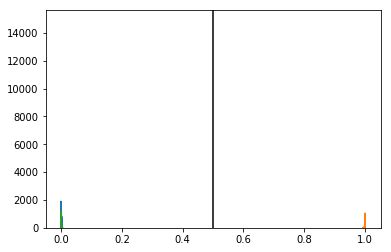

In [88]:
sns.distplot(logistic_regression.predict_proba(X_train[y_train==0])[:,1])
sns.distplot(logistic_regression.predict_proba(X_train[y_train==1])[:,1])
sns.distplot(logistic_regression.predict_proba(X_train[y_train==2])[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)

**Classification Report**

<a id="sec_lr_gs"></a> 
#### Optimizacion de hiperparametros mediante GridSearchCV

[volver a TOC](#section_toc)

**Stratified K-Folds**

Utilizacion de separacion en _folds_ los registros del dataset de training para utilizar en una estrategia de cross validation.
Los _folds_ utilizan features estadarizados previamente y permiten preservar el porcentaje de muestras para cada clase.

In [89]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [90]:
#Hiperparametros del modelo.
c = np.arange(100, 1000, 100)
solver =  ['newton-cg', 'lbfgs']
m_iter = [1000]
e_penalty = ['l2', 'l1', 'elasticnet', 'none'],

# Metricas de evaluacion
scoring = ['accuracy', 'precision_macro', 'recall_macro']

In [91]:
logreg=LogisticRegression()

In [92]:
logreg_grid = dict(max_iter=m_iter, solver=solver, C=c)
print(logreg_grid)

{'max_iter': [1000], 'solver': ['newton-cg', 'lbfgs'], 'C': array([100, 200, 300, 400, 500, 600, 700, 800, 900])}


Creacion de la grilla de hiperparametros del modelo

In [93]:
logreg_cv = GridSearchCV(logreg, logreg_grid, refit='accuracy', n_jobs = -1, cv=skf, return_train_score=True, scoring=scoring)

In [94]:
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                         'max_iter': [1000], 'solver': ['newton-cg', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'preci

In [95]:
logreg_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_max_iter', 'param_solver', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_accuracy', 'split4_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy', 'split0_test_precision_macro', 'split1_test_precision_macro', 'split2_test_precision_macro', 'split3_test_precision_macro', 'split4_test_precision_macro', 'mean_test_precision_macro', 'std_test_precision_macro', 'rank_test_precision_macro', 'split0_train_precision_macro', 'split1_train_precision_macro', 'split2_train_precision_macro', 'split3_train_precision_macro', 'split4_train_precision_macro', 'mean_train_precision_macro', 'std_train_precision_macro', 'split0_test_recall_macro', 'split1_test_recall_m

In [96]:
logreg_cv_results = pd.DataFrame(logreg_cv.cv_results_)
pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_accuracy,split1_test_accuracy,...,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_train_recall_macro,split1_train_recall_macro,split2_train_recall_macro,split3_train_recall_macro,split4_train_recall_macro,mean_train_recall_macro,std_train_recall_macro
7,0.975790,0.051091,1.091083,0.094379,manhattan,4,distance,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.920792,0.881188,...,0.901007,0.038512,1,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
11,1.071534,0.066613,1.165284,0.088302,manhattan,6,distance,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.930693,0.841584,...,0.889354,0.038570,2,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
15,1.060962,0.114899,1.198595,0.069079,manhattan,8,distance,"{'metric': 'manhattan', 'n_neighbors': 8, 'wei...",0.910891,0.861386,...,0.887573,0.031627,3,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000
10,0.964021,0.063678,1.091282,0.076136,manhattan,6,uniform,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.900990,0.831683,...,0.884942,0.039898,7,0.92536,0.927093,0.938463,0.927421,0.928111,0.92929,0.004676
23,1.071135,0.051804,1.138955,0.078528,manhattan,12,distance,"{'metric': 'manhattan', 'n_neighbors': 12, 'we...",0.891089,0.851485,...,0.885746,0.037410,4,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000


In [97]:
logreg_cv_results.shape

(18, 53)

In [98]:
print(logreg_cv.best_estimator_)
print(logreg_cv.best_score_)
print(logreg_cv.best_params_)

LogisticRegression(C=700, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9342376237623762
{'C': 700, 'max_iter': 1000, 'solver': 'lbfgs'}


<a id="sec_lr_eval"></a> 
#### Metricas y evaluacion del modelo

[volver a TOC](#section_toc)

In [99]:
y_test_pred = logistic_regression.predict(X_test)

**Matriz de confusion**

In [100]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[55,  0,  2],
       [ 0, 55,  3],
       [ 3,  3, 47]], dtype=int64)

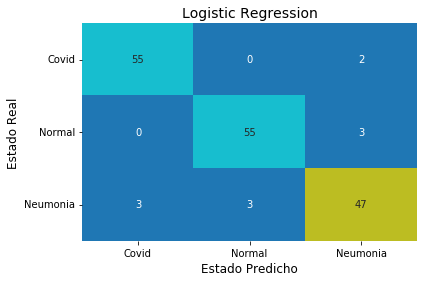

In [101]:
xticks=['Covid','Normal', 'Neumonia']
yticks=['Covid','Normal', 'Neumonia']

sns.heatmap(cm, annot=True, xticklabels=xticks, yticklabels=yticks, cbar=False, fmt='.0f', cmap="tab10")

plt.yticks(rotation=0, fontsize="10", va="center")
plt.title('Logistic Regression', fontsize = 14)
plt.ylabel('Estado Real', fontsize = 12)
plt.xlabel('Estado Predicho', fontsize = 12)

plt.show()

**Classification Report**

In [102]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96        57
           1       0.95      0.95      0.95        58
           2       0.90      0.89      0.90        53

    accuracy                           0.93       168
   macro avg       0.93      0.93      0.93       168
weighted avg       0.93      0.93      0.93       168



**Metricas**

Asigamos variable a la matriz de confusión

In [103]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [104]:
accuracy_lr = accuracy_score(y_test, y_test_pred).round(2)
print('Accuracy=', accuracy_score(y_test, y_test_pred).round(2)*100,'%')

Accuracy= 93.0 %


**Sensitivity (o recall)**

TP / TP + FN

In [105]:
recall_lr = (TP / (TP + FN)).round(2)
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

recall= 89.0 %


**Specificity**

TN / (TN + FP)

In [106]:
specificity_lr = (TN / (TN + FP)).round(2)
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

Specificity= 95.0 %


**Precision**

TP / (TP + FP)

In [107]:
precision_lr = (TP / (TP + FP)).round(2)
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')

Precision= 90.0 %


**False positive rate (FPR)**

(1 - Specificity)

In [108]:
fpr_lr = (1 - (TN / (TN + FP))).round(2)
print('FPR=',100 - ((TN / (TN + FP))).round(2) * 100,'%')

FPR= 5.0 %


**F1-Score**

2*(Precision * Recall) / precision + Recall

In [109]:
f1s_lr = 2*((precision_lr * recall_lr) / (precision_lr + recall_lr)).round(2)
print ('F1-Score=', 2*((precision_lr * recall_lr) / (precision_lr + recall_lr)).round(2)*100,'%')

F1-Score= 90.0 %


*Conclusión:*  vemos que logramos aumentar los indicadores.   

* Tenemos un porcentaje alto de casos que han sido clasificados correctamente (**Accuracy**)
* nuestro modelo está teniendo un alto rendimiento para detectar pacientes sanos en relación a las que realmente estan sanos (**Sensitivity**)
* El modelo es muy específico, cometió pocos errores de falsos positivos (**Specificity**)
* Es muy preciso. De cada 100 predicciones positivas que realiza el modelo (es decir, predice que un paciente este sano), acierta un porcentaje muy alto (**Precision**).
* Logramos bajar la cantidad de casos clasificados como sanos cuando estan enfermos, a la mitad (**False positive rate**)

In [110]:
results=logreg_cv.cv_results_
#results.keys()
X_axis = np.linspace(0, len(results['mean_test_accuracy']),18)

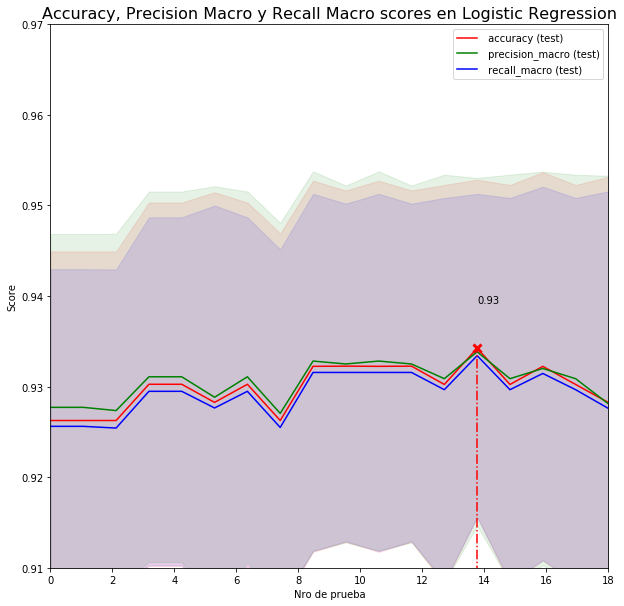

In [111]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy, Precision Macro y Recall Macro scores en Logistic Regression",fontsize=16)

plt.xlabel("Nro de prueba")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 18)
ax.set_ylim(0.91, 0.97)

for scorer, color in zip(sorted(scoring), ['r', 'g', 'b']):

    sample, style = ('test', '-')
    sample_score_mean = results[f'mean_{sample}_{scorer}']
    sample_score_std = results[f'std_{sample}_{scorer}']

    ax.fill_between(X_axis, sample_score_mean - sample_score_std, sample_score_mean + sample_score_std, alpha=0.1 if sample == 'test' else 0, color=color)
    ax.plot(X_axis, sample_score_mean, style, color=color, alpha=1 if sample == 'test' else 0.7, label=f' {scorer} ({sample})')

best_index = np.nonzero(results['rank_test_accuracy'] == 1)[0][0]
best_score = results['mean_test_accuracy'][best_index]

ax.plot([X_axis[best_index], ] * 2, [0, best_score], linestyle='-.', color='r', marker='x', markeredgewidth=3, ms=8)

ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

---

<a id="sec_conclusiones"></a> 
## Conclusiones

[volver a TOC](#section_toc)

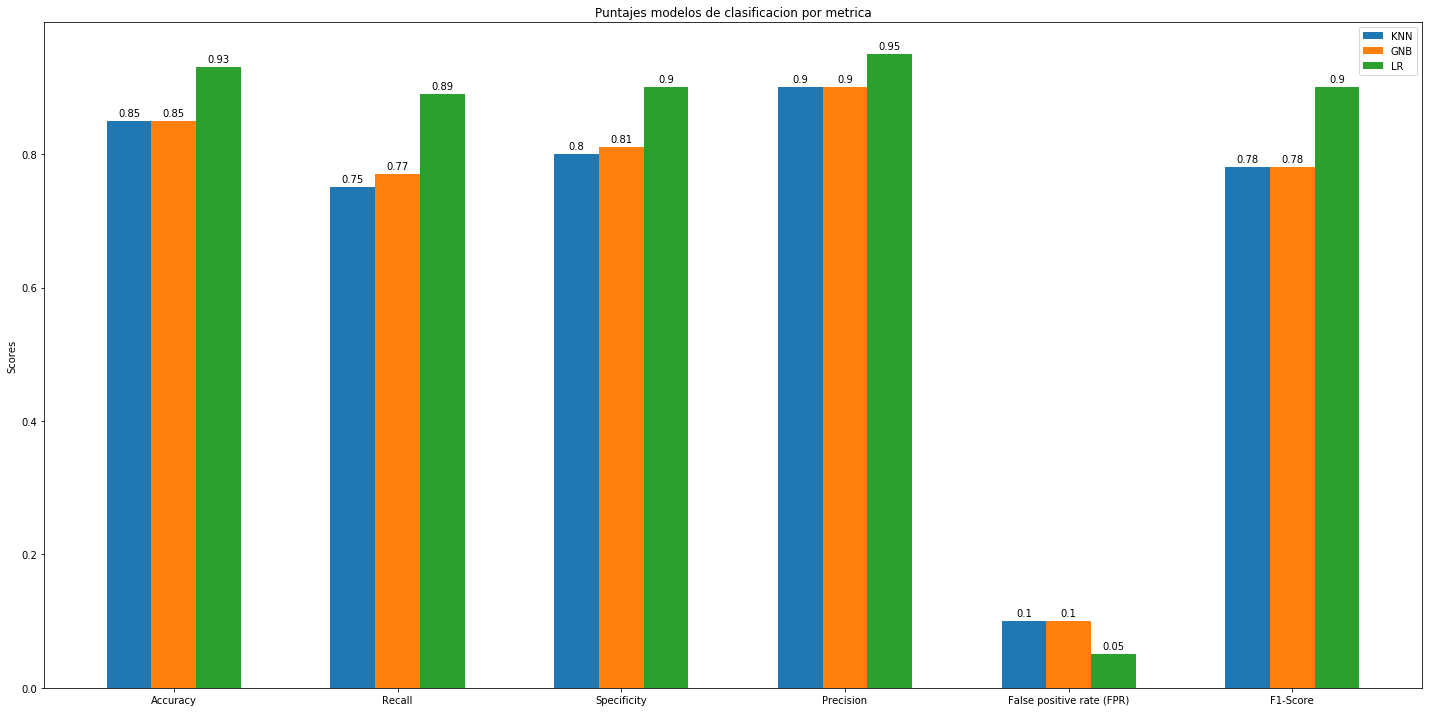

In [112]:
labels = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'False positive rate (FPR)', 'F1-Score']
knn_metrics = [accuracy_knn, recall_knn, precision_knn, specificity_knn, fpr_knn, f1s_knn]
gnb_metrics = [accuracy_gnb, recall_gnb, precision_gnb, specificity_gnb, fpr_gnb, f1s_gnb]
lr_metrics = [accuracy_lr, recall_lr, precision_lr, specificity_lr, fpr_lr, f1s_lr]
#pipe_metrics = [accuracy_gnb, recall_gnb, precision_gnb, specificity_gnb, fpr_gnb, f1s_gnb]

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))

rects1 = ax.bar(x, knn_metrics, width, label='KNN')
rects2 = ax.bar(x + width, gnb_metrics, width, label='GNB')
rects3 = ax.bar(x + width*2, lr_metrics, width, label='LR')
#rects4 = ax.bar(x + width*3, gnb_metrics, width, label='Pipeline') # pipelines

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Puntajes modelos de clasificacion por metrica')
ax.set_xticks(x+width*1)
ax.set_xticklabels(labels, ha='center')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
#autolabel(rects4)

fig.tight_layout()

plt.show()
